# XAI Experiment Data Analysis

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import json
import pandas as pd
import requests
import io
from urllib.request import urlopen
import json
import logging
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.json import json_normalize
import pingouin as pg
import scikit_posthocs as sp

In [3]:
%reload_ext autoreload
%autoreload 2

## Import and preprocess data

### Read questionnaire data

In [4]:
df = pd.read_csv('data/data_cleaned.csv')

### Read news items

In [5]:
newsitems = pd.read_csv('../preprocessing/news-items.csv')

In [6]:
newsitems["id"] = newsitems.index + 1
newsitems.index = newsitems.index + 1

In [7]:
# only keep the relevant columns
newsitems = newsitems[["id", "label", "group",
                       "title", "subtitle", "content",
                       "source", "publishing_date", "category",
                       "highlighted_content", "truthfulness", "readability","natural_language_explanation",
                       "is_qualification"]]

In [8]:
# only keep newsitems from group 2 and newsitems without a group (FP and TN), 
# since only these are used in the experiment
newsitems = newsitems[(newsitems["group"] == 2) | newsitems["group"].isna()]
newsitems = newsitems.drop(columns=["group"])

In [9]:
# create a new column, "is_fake_news", based on if "label" is "FAKE" or "TRUE"
newsitems["is_fake_news"] = newsitems["label"].apply(lambda x: True if x == "FAKE" else False)
newsitems = newsitems.drop(columns=["label"])

In [10]:
# remove percentage sign from truthfulness and convert to int
newsitems["truthfulness"] = newsitems["truthfulness"].apply(lambda x: int(x.replace("%", "")))

In [11]:
newsitems.head()

,id,title,subtitle,content,source,publishing_date,category,highlighted_content,truthfulness,readability,natural_language_explanation,is_qualification,is_fake_news
7,7,"Facing unbearable heat, Qatar has begun to air...",2°C: BEYOND THE LIMIT,"Already one of the hottest places on Earth, Qa...",Trustworthy Source,10/16/2019,Environment,"Already one of the hottest places on Earth, Qa...",90,medium,Qatar is one of the hottest countries on earth...,False,False
8,8,Survival International launches campaign to st...,NaN,Survival International today (Earth Day) launc...,Untrustworthy Source,04/22/2022,Environment,Survival International today (Earth Day) launc...,47,medium,The statement by Survival International that 3...,False,True
9,9,How Biden's climate plan could limit you to ea...,NaN,President Joe Biden's ambitious plan to slash ...,Untrustworthy Source,04/22/2021,Environment,President Joe Biden's ambitious plan to <span ...,5,easy,President Joe Biden’s climate plans do not inc...,False,True
10,10,Several Israelis wounded in attack on Jerusale...,Israeli police arrest suspected gunman after a...,Israeli police arrested a suspect in a shootin...,Trustworthy Source,8/14/2022,Crime,"""<mark>Israeli police arrested a suspect in a ...",92,medium,Israeli forces have allegedly been raiding hou...,True,False
11,11,Young Girl Hitchhiked Through The Middle East ...,NaN,Here’s a shocking and sad story that should be...,Untrustworthy Source,4/14/2016,Crime,"""<span style='background-color:#00FEFE'>Here’s...",21,easy,The article misleads the readers about the tim...,False,True


### Filtering out assumed cheaters

In [12]:
# journalists were part of the experiment, but are not part of this analysis
def lay(data):
    return data[data["JOURNALIST"] == False]

In [13]:
df = lay(df)

In [14]:
df.groupby("FEATURE").count()["POINTS"].to_frame()

,POINTS
FEATURE,
basic,142
explanations,141
salient,145


Assume that participants who did answer at least 5 out of 6 control questions correctly were paying attention and gave valid answers.

In [15]:
# participants who did not get 2 points in the qualification shouldn't be considered
# journalists don't have a qualification score, so they should be kept
df = df[(df["POINTS.qualification"].isna()) | (df['POINTS.qualification'] == 2)]

In [16]:
# journalists don't have a main score, so they should be kept
df = df[(df["POINTS.main"].isna()) | (df["POINTS.main"] >= 5)]

In [17]:
# filter out journalists who didn't reach enough points in the merged task
df = df[df["POINTS"] >= 7]

In [18]:
df.groupby("FEATURE").count()["POINTS"].to_frame()

,POINTS
FEATURE,
basic,133
explanations,133
salient,140


## Time to complete the questionnaire

In [19]:
df["METADATA.workDurationInMinutes.qualification"] = df["METADATA.workDurationInSeconds.qualification"] / 60
df["METADATA.workDurationInMinutes.main"] = df["METADATA.workDurationInSeconds.main"] / 60

In [20]:
df["METADATA.workDurationInMinutes.qualification"].describe()

count    406.000000
mean      16.932061
std       10.382728
min        4.016667
25%       10.120833
50%       14.316667
75%       19.979167
max       71.900000
Name: METADATA.workDurationInMinutes.qualification, dtype: float64

In [21]:
df["METADATA.workDurationInMinutes.main"].describe()

count    406.000000
mean      21.014204
std       11.751090
min        4.133333
25%       13.320833
50%       18.108333
75%       25.412500
max       89.100000
Name: METADATA.workDurationInMinutes.main, dtype: float64

## Demographics

In [22]:
# get columns which start with "demographics"
demographics_cols = [col for col in df.columns if col.startswith('demographics')]
demographics_cols
# country and nationality are not relevant, since the study was conducted in the US

['demographics.age',
 'demographics.country',
 'demographics.education',
 'demographics.employment',
 'demographics.gender',
 'demographics.income',
 'demographics.nationality']

In [23]:
df["demographics.age"].value_counts().sort_index()

18-20           16
21-29          105
30-39          156
40-49           93
50-59           28
60-or-older      8
Name: demographics.age, dtype: int64

In [24]:
df["demographics.education"].value_counts()
# university degree is the most common education level, this is surprising

university         220
high-school        161
no-degree           11
secondary            9
upper-secondary      5
Name: demographics.education, dtype: int64

In [25]:
df["demographics.employment"].value_counts()

salaried-employee    148
self-employed        129
unemployed            55
student               40
other                 26
civil-servant          3
retiree-pensioner      3
apprentice             2
Name: demographics.employment, dtype: int64

In [26]:
income_vc = df["demographics.income"].value_counts()
print("less-than-20000-usd\t", income_vc["less-than-20000-usd"])
print("20000-34999-usd\t\t", income_vc["20000-34999-usd"])
print("35000-49999-usd\t\t", income_vc["35000-49999-usd"])
print("50000-74999-usd\t\t", income_vc["50000-74999-usd"])
print("75000-99999-usd\t\t", income_vc["75000-99999-usd"])
print("over-100000-usd\t\t", income_vc["over-100000-usd"])
print("no-answer\t\t", income_vc["no-answer"])

less-than-20000-usd	 58
20000-34999-usd		 72
35000-49999-usd		 44
50000-74999-usd		 83
75000-99999-usd		 49
over-100000-usd		 55
no-answer		 45


In [27]:
df["demographics.gender"].value_counts(normalize=True) * 100

female     63.546798
male       35.714286
diverse     0.738916
Name: demographics.gender, dtype: float64

In [28]:
gender = df["demographics.gender"].value_counts()

In [29]:
import pandas as pd

demographics_table = pd.DataFrame(columns=["demographic attribute", "value", "count", "percentage"])

def add_attribute(column_name, attr_name, value_map=None):
    order = None
    if value_map is None or len(value_map) != len(df[column_name].value_counts()):
        order = df[column_name].value_counts().index
    else:
        order = value_map.keys()

    for i, value in enumerate(order):
        count = df[column_name].value_counts()[value]
        percentage = count / len(df) * 100

        if value_map is not None and value in value_map:
            value = value_map[value]

        demographics_table.loc[len(demographics_table)] = [attr_name if i == 0 else np.nan, value, count, percentage]

add_attribute("demographics.gender", "Gender", value_map={
     "female": "Female", 
     "male": "Male", 
     "diverse": "Diverse"
})
add_attribute("demographics.age", "Age", value_map={
    "18-20": "18-20",
    "21-29": "21-29",
    "30-39": "30-39",
    "40-49": "40-49",
    "50-59": "50-59",
    "60-or-older": "60 or older"
})
add_attribute("demographics.education", "Education", value_map={
    "no-degree": "No degree",
    "secondary": "Secondary/elementary school diploma",
    "upper-secondary": "Upper secondary school",
    "high-school": "High school diploma",
    "university": "University degree",
})
add_attribute("demographics.employment", "Employment", value_map={
    "apprentice": "Apprentice",
    "student": "Student",
    "salaried-employee": "Salaried employee",
    "self-employed": "Self-employed",
    "civil-servant": "Civil servant",
    "retiree-pensioner": "Retiree / pensioner",
    "unemployed": "Unemployed",
    "other": "Other",
})
add_attribute("demographics.income", "Income", value_map={
    "no-answer": "I do not want to answer",
    "less-than-20000-usd": "Less than \$20.000",
    "20000-34999-usd": "\$20.000 - \$34.999",
    "35000-49999-usd": "\$35.000 - \$49.999",
    "50000-74999-usd": "\$50.000 - \$74.999",
    "75000-99999-usd": "\$75.000 - \$99.999",
    "over-100000-usd": "Over \$100.000",
})

print(demographics_table.to_latex(index=False, escape=False, na_rep="", float_format="%.2f", longtable=True, caption="Demographic Data", label="tab:demographics"))

\begin{longtable}{llrr}
\caption{Demographic Data}
\label{tab:demographics}\\
\toprule
demographic attribute &                               value &  count &  percentage \\
\midrule
\endfirsthead
\caption[]{Demographic Data} \\
\toprule
demographic attribute &                               value &  count &  percentage \\
\midrule
\endhead
\midrule
\multicolumn{4}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
               Gender &                              Female &    258 &       63.55 \\
                      &                                Male &    145 &       35.71 \\
                      &                             Diverse &      3 &        0.74 \\
                  Age &                               18-20 &     16 &        3.94 \\
                      &                               21-29 &    105 &       25.86 \\
                      &                               30-39 &    156 &       38.42 \\
                      &                   

## Define helper functions

### Define highlight function

In [30]:
# underlines p-values in a dataframe that are smaller than alpha
def highlight(data, highlight_any=False, alpha=0.05):
    columns = ["p-val", "p-unc", "p-corr", "p", "pval"]

    if highlight_any:
        columns = data.columns
        
    return data.style.apply(lambda x: ["text-decoration: underline" if isinstance(v, (int, float)) and v < alpha and c in columns else "" for c, v in zip(x.index, x)], axis=1)

### Define Cohen's d function

In [31]:
def cohen_d(d1, d2):
 # calculate the size of samples
 n1, n2 = len(d1), len(d2)
 # calculate the variance of the samples
 s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
 # calculate the pooled standard deviation
 s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
 # calculate the means of the samples
 u1, u2 = np.mean(d1), np.mean(d2)
 # calculate the effect size
 return (u1 - u2) / s

### Define Kruskal-Wallis test function

In [32]:
from itertools import combinations

def perform_kruskal_with_posthoc(df, dv, between="FEATURE", print_results=True, between_values_order=None):
    kruskal_test = pg.kruskal(df, dv=dv, between=between, detailed=True)
    kruskal_pval = kruskal_test["p-unc"].values[0]

    dunn = sp.posthoc_dunn(df, val_col=dv, group_col=between, p_adjust="holm")

    values = df[between].unique() if not between_values_order else between_values_order
    pairs = list(combinations(values, 2))

    posthoc = pd.DataFrame(columns=["A", "B", "p-corr", "cohen"])

    # create a dataframe for the posthoc results
    for pair in pairs:
        posthoc = posthoc.append(
            {
                "A": pair[0],
                "B": pair[1],
                "p-corr": dunn.loc[pair[0], pair[1]],
                "cohen": cohen_d(df[df[between] == pair[0]][dv], df[df[between] == pair[1]][dv]),
            },
            ignore_index=True,
        )

    if print_results:
        print("Column name:", dv)
        print("kruskal_pval", kruskal_pval, "\n")
        print(posthoc, "\n")
        print(df.groupby(between)[dv].describe()[["mean", "std"]], "\n")

    return kruskal_test, posthoc, df.groupby(between)[dv].describe()[["count", "mean", "std"]]

### Define Latex formatting functions

In [33]:
def format_posthoc(pairwise, caption, label, between_col_mapping, column_a_name="System A", column_b_name="System B"):
    pairwise_latex = pairwise.copy()

    # replace "ai_accuracy" with "AI", "human_accuracy" with "Human" and "human_ai_accuracy" with "Human-AI"
    pairwise_latex["A"] = pairwise_latex["A"].apply(lambda x: between_col_mapping[x])
    pairwise_latex["B"] = pairwise_latex["B"].apply(lambda x: between_col_mapping[x])

    pairwise_latex = pairwise_latex.rename(columns={
        "A": column_a_name,
        "B": column_b_name,
        "p-corr": "$p$",
        "cohen": "Cohen's $d$"
    })

    # if p < 0.01, replace p with "<.01"
    pairwise_latex["$p$"] = pairwise_latex["$p$"].apply(lambda x: "$<.01$" if x < 0.01 else f"${x:.2f}$".replace('0.','.'))

    caption = caption + " " + "($p$-values corrected with the Holm-Bonferroni method)"

    print(pairwise_latex.to_latex(
        index=False, 
        escape=False, 
        na_rep="", 
        float_format="%.2f", 
        column_format="llrr",
        caption=caption, 
        label=f"tab:{label}"))

In [34]:
def print_kruskal_latex(kruskal_df):
    res = ""

    if kruskal_df["p-unc"].values[0] < 0.01:
        print(f"(H=${kruskal['H'].values[0]:.2f}$, $p$-value=$<.01$)")
    else:
        res = f"(H=${kruskal['H'].values[0]:.2f}$, $p$-value=${kruskal['p-unc'].values[0]:.2f}$)"
        res = res.replace("$p$-value=$0.", "$p$-value=$.")
        print(res)

## Performance

### AI vs Human vs Human-AI

How does the AI system perform compared to humans and the combination of humans and AI? 

The task is to judge whether a news item is fake news or not, thus this is a binary classification problem. Since both the AI and participants are asked to rate the news items on a 0-100 scale, we use a threshold of 50, where ratings of <50 are treated as predicted fake news and ratings >=50 are treated as predicted truthful news.

The metrics for the AI are calculated over the 8 news items. Metrics are calculated for each participant separately over the presented news items (e.g. a participant correctly judged 6 out of 8 news items, thus the accuracy for the participant is 6/8 = 0.75). Human-AI performance is measured after presenting the AI rating to the participants, this is also calculated for each participant separately.

### Calculate performance metrics of the AI system

In [35]:
RATING_THRESHOLD = 50

newsitems["is_fake_news_pred"] = newsitems["truthfulness"] < RATING_THRESHOLD

In [36]:
newsitems["is_fake_news"].value_counts()

True     5
False    3
Name: is_fake_news, dtype: int64

Since the dataset is unbalanced (5 fake news items and 3 truthful news items), we also use metrics that are more robust to unbalanced datasets than accuracy, such as F1-score and ROC AUC. Furthermore, a Brier score is calculated to measure the accuracy of the predicted probabilities.

In [37]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, brier_score_loss

ai_accuracy = accuracy_score(newsitems["is_fake_news"], newsitems["is_fake_news_pred"])
ai_f1 = f1_score(newsitems["is_fake_news"], newsitems["is_fake_news_pred"])
ai_roc_auc = roc_auc_score(newsitems["is_fake_news"], 1 - (newsitems["truthfulness"] / 100))
ai_brier_score = brier_score_loss(
    newsitems["is_fake_news"],
    newsitems["truthfulness"] / 100, 
    pos_label=0
)

ai_performance_df = pd.DataFrame({
  "accuracy": [ai_accuracy],
  "f1": [ai_f1],
  "roc_auc_score": [ai_roc_auc],
  "brier_score": [ai_brier_score]
})

ai_performance_df

,accuracy,f1,roc_auc_score,brier_score
0,0.75,0.8,0.666667,0.254462


### Calculate performance metrics of the participants and Human-AI teams

In [38]:
def calculate_human_metrics(row):
    y_true = newsitems["is_fake_news"]
    y_pred_human = []
    y_pred_human_prob = []
    y_pred_human_ai = []
    y_pred_human_ai_prob = []

    for i in y_true.index:
        y_pred_human.append(row[f"newsitem.{i}.rating-before-xai"] < 50)
        y_pred_human_prob.append(row[f"newsitem.{i}.rating-before-xai"] / 100)
        y_pred_human_ai.append(row[f"newsitem.{i}.rating-after-xai"] < 50)
        y_pred_human_ai_prob.append(row[f"newsitem.{i}.rating-after-xai"] / 100)

    for i, _id in enumerate(y_true.index):
        # will be used later for comparing news items
        row[f"newsitem.{_id}.rating-before-correct"] = y_true[_id] == y_pred_human[i]
        row[f"newsitem.{_id}.rating-after-correct"] = y_true[_id] == y_pred_human_ai[i]

    human_accuracy = accuracy_score(y_true, y_pred_human)
    human_f1 = f1_score(y_true, y_pred_human)
    human_roc_auc = roc_auc_score(y_true, 1 - np.array(y_pred_human_prob))
    human_brier_score = brier_score_loss(y_true, y_pred_human_prob, pos_label=0)

    human_ai_accuracy = accuracy_score(y_true, y_pred_human_ai)
    human_ai_f1 = f1_score(y_true, y_pred_human_ai)
    human_ai_roc_auc = roc_auc_score(y_true, 1 - np.array(y_pred_human_ai_prob))
    human_ai_brier_score = brier_score_loss(y_true, y_pred_human_ai_prob, pos_label=0)

    row["human_accuracy"] = human_accuracy
    row["human_f1"] = human_f1
    row["human_roc_auc_score"] = human_roc_auc
    row["human_brier_score"] = human_brier_score

    row["human_ai_accuracy"] = human_ai_accuracy
    row["human_ai_f1"] = human_ai_f1
    row["human_ai_roc_auc_score"] = human_ai_roc_auc
    row["human_ai_brier_score"] = human_ai_brier_score

    return row

df = df.apply(calculate_human_metrics, axis=1)

#### Compare AI vs Human vs Human-AI

To compare the performance of the AI system to the performance of the participants and Human-AI teams, we average the metrics across the participants.

In [39]:
# show mean human scores, mean human_ai scores and ai scores in one dataframe
human_scores = df[[
    "human_accuracy", 
    "human_f1", 
    "human_roc_auc_score",
    "human_brier_score",
]].copy()

human_ai_scores = df[[
    "human_ai_accuracy", 
    "human_ai_f1", 
    "human_ai_roc_auc_score",
    "human_ai_brier_score",
]].copy()

human_scores = human_scores.rename(columns=lambda x: x.replace("human_", ""))
human_ai_scores = human_ai_scores.rename(columns=lambda x: x.replace("human_ai_", ""))

human_scores = human_scores.mean()
human_ai_scores = human_ai_scores.mean()


In [40]:
scores_df = pd.DataFrame({
  "AI": ai_performance_df.iloc[0],
  "Human (mean)": human_scores,
  "Human-AI (mean)": human_ai_scores,
})

scores_df = scores_df.rename(index={
    "accuracy": "Accuracy",
    "f1": "F1 score",
    "roc_auc_score": "ROC AUC",
    "brier_score": "Brier score"
})


scores_df

,AI,Human (mean),Human-AI (mean)
Accuracy,0.750000,0.730911,0.818350
F1 score,0.800000,0.749796,0.840796
ROC AUC,0.666667,0.806076,0.884975
Brier score,0.254462,0.181032,0.134820


In [41]:
print(scores_df.to_latex(escape=False, na_rep="", float_format="%.2f", caption="Performance of the AI vs human participants vs Human-AI teams across different metrics", label="tab:performance"))

\begin{table}
\centering
\caption{Performance of the AI vs human participants vs Human-AI teams across different metrics}
\label{tab:performance}
\begin{tabular}{lrrr}
\toprule
{} &   AI &  Human (mean) &  Human-AI (mean) \\
\midrule
Accuracy    & 0.75 &          0.73 &             0.82 \\
F1 score    & 0.80 &          0.75 &             0.84 \\
ROC AUC     & 0.67 &          0.81 &             0.88 \\
Brier score & 0.25 &          0.18 &             0.13 \\
\bottomrule
\end{tabular}
\end{table}



#### AI vs Human vs Human-AI

We use a Kruskal-Wallis test to determine if there is a significant difference in AI performance vs participants' performance before and after seeing the AI scores (and explanations).

In [42]:
df["ai_accuracy"] = ai_accuracy

In [43]:
# create a new dataframe with human_accuracy, human_ai_accuracy and ai_accuracy
accuracy_df = df[["human_accuracy", "human_ai_accuracy", "ai_accuracy"]].copy()

# transform the dataframe to a long format
accuracy_df = pd.melt(
  accuracy_df.reset_index(),
  id_vars=["index"],
  value_vars=["human_accuracy", "human_ai_accuracy", "ai_accuracy"]
)

# rename the columns
accuracy_df = accuracy_df.rename(columns={
  "variable": "system",
  "value": "accuracy"
})

In [44]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(accuracy_df, 
    dv='accuracy', 
    between='system', 
    print_results=False, 
    between_values_order=["human_accuracy", "ai_accuracy", "human_ai_accuracy"])

In [45]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,system,2,108.817478,0.000000


In [46]:
print_kruskal_latex(kruskal)

(H=$108.82$, $p$-value=$<.01$)


In [47]:
highlight(posthoc)

,A,B,p-corr,cohen
0,human_accuracy,ai_accuracy,0.531421,-0.170664
1,human_accuracy,human_ai_accuracy,0.000000,-0.589856
2,ai_accuracy,human_ai_accuracy,0.000000,-0.702588


In [48]:
format_posthoc(posthoc,
  caption="Pairwise comparisons of the accuracy using Dunn's tests",
  label='accuracy_pairwise',
  between_col_mapping={
    'ai_accuracy': 'AI',
    'human_accuracy': 'Human',
    'human_ai_accuracy': 'Human-AI'
  })

\begin{table}
\centering
\caption{Pairwise comparisons of the accuracy using Dunn's tests ($p$-values corrected with the Holm-Bonferroni method)}
\label{tab:accuracy_pairwise}
\begin{tabular}{llrr}
\toprule
System A & System B &    $p$ &  Cohen's $d$ \\
\midrule
   Human &       AI &  $.53$ &        -0.17 \\
   Human & Human-AI & $<.01$ &        -0.59 \\
      AI & Human-AI & $<.01$ &        -0.70 \\
\bottomrule
\end{tabular}
\end{table}



p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ai_accuracy vs. human_accuracy: Custom statistical test, P_val:5.314e-01
human_accuracy vs. human_ai_accuracy: Custom statistical test, P_val:3.157e-20
ai_accuracy vs. human_ai_accuracy: Custom statistical test, P_val:6.362e-18


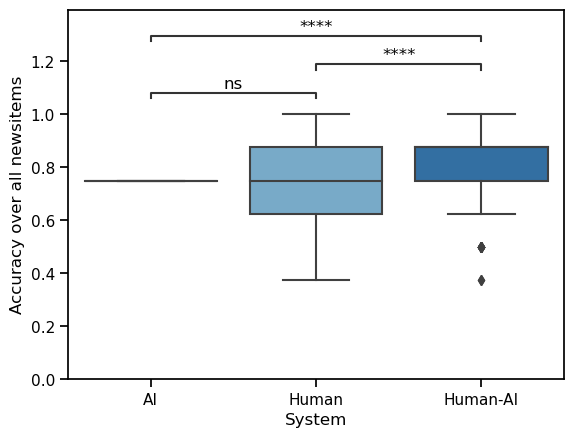

In [49]:
from itertools import combinations
from statannotations.Annotator import Annotator

values = ["ai_accuracy", "human_accuracy", "human_ai_accuracy"]
pairs = list(combinations(values, 2))

plot_params = {
  "x": "system",
  "y": "accuracy",
  "data": accuracy_df,
  "palette": "Blues",
  "order": values,
}

with sns.plotting_context('notebook'):
    ax = sns.boxplot()

    sns.boxplot(**plot_params).set(xlabel='System', ylabel='Accuracy over all newsitems')

    ax.set_ylim([0, 1])
    ax.set_xticklabels(["AI", "Human", "Human-AI"])

    p_values = []
    for pair in pairs:
        p_val = posthoc[(
            (posthoc["A"] == pair[0]) & (posthoc["B"] == pair[1]) | 
            (posthoc["B"] == pair[0]) & (posthoc["A"] == pair[1]))]["p-corr"]

        p_values.append(p_val.values[0])

    # Add annotations
    annotator = Annotator(ax, pairs, **plot_params)
    annotator.set_pvalues_and_annotate(p_values,)

    plt.show()

In [50]:
wilcoxon = pg.wilcoxon(df["human_accuracy"], df["human_ai_accuracy"])

In [51]:
highlight(wilcoxon)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,5429.500000,two-sided,0.000000,-0.694207,0.345625


### Compare Human-AI performance among groups (v1 vs v2 vs v3)

We use a Kruskal-Wallis H-test to determine if there is a significant difference in the accuracy of the Human-AI teams among the groups.

In [52]:
kruskal, pairwise, stats = perform_kruskal_with_posthoc(df, "human_ai_accuracy", print_results=False);

In [53]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,0.320474,0.851942


In [54]:
print_kruskal_latex(kruskal)

(H=$0.32$, $p$-value=$.85$)


In [55]:
stats

,count,mean,std
FEATURE,,,
basic,133.0,0.815789,0.132876
explanations,133.0,0.822368,0.150921
salient,140.0,0.816964,0.129341


### Compare the change in performance among groups (v1 vs v2 vs v3)

In [56]:
df["accuracy_change"] = df["human_ai_accuracy"] - df["human_accuracy"]

In [57]:
df["accuracy_change"].describe().loc[["count", "mean", "std"]]

count    406.000000
mean       0.087438
std        0.152568
Name: accuracy_change, dtype: float64

On average, the accuracy of the participants increased by 0.087438 after seeing the AI score. We use a Kruskal-Wallis H-test to determine if there is a significant difference in the change in performance of the participants among the groups.

In [58]:
kruskal, pairwise, stats = perform_kruskal_with_posthoc(df, "accuracy_change", print_results=False);

In [59]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,5.674691,0.058581


In [60]:
stats

,count,mean,std
FEATURE,,,
basic,133.0,0.106203,0.139751
explanations,133.0,0.084586,0.168935
salient,140.0,0.072321,0.146963


## Willingness to adjust judgments to match the AI system

We use three metrics to measure the willingness of the participants to adjust their judgments to match the AI system:
- Agreement percentage: percentage of news items in which the participant’s final prediction agreed with the AI’s prediction (adapted from [1] and [2])
- Switch percentage: percentage of news items in which the participant revised their predictions to match the model’s predictions (adapted from [1] and [2])
- AI-preference: a number between 0 and 1 that indicates the degree to which the participant prefers the AI’s prediction over their own original prediction. This is defined for individual news item ratings of one participant. It is defined as:

$$
ai\_preference = 
\begin{cases}
1 & \text{if } rating_{before} = ai\_rating \text{ and } ai\_rating = rating_{after} \\
0 & \text{if } rating_{before} = ai\_rating \text{ and } ai\_rating \neq rating_{after} \\
\min(1, \max(0, \frac{rating_{after} - rating_{before}}{ai\_rating - rating_{before}})) & \text{otherwise}
\end{cases}
$$

[1]: https://dl.acm.org/doi/10.1145/3290605.3300509 
[2]: https://dl.acm.org/doi/10.1145/3351095.3372852

### Calculate willingness to adjust metrics

In [61]:
def agrees_with_ai(row, newsitem_id):
    ai_rating = newsitems[newsitems["id"] == newsitem_id]["truthfulness"].values[0]
    human_rating = row[f"newsitem.{newsitem_id}.rating-after-xai"]
    return (human_rating < 50) == (ai_rating < 50)

def switched_ratings(row, newsitem_id):
    ai_rating = newsitems[newsitems["id"] == newsitem_id]["truthfulness"].values[0]
    human_rating_before = row[f"newsitem.{newsitem_id}.rating-before-xai"]
    human_rating_after = row[f"newsitem.{newsitem_id}.rating-after-xai"]
    
    return ((human_rating_before < 50) != (human_rating_after < 50)
            ) and ((human_rating_after < 50) == (ai_rating < 50))

def calculate_ai_preference(row, newsitem_id):
    rating_before_col = f"newsitem.{i}.rating-before-xai"
    rating_after_col = f"newsitem.{i}.rating-after-xai"
    ai_rating = newsitems[newsitems["id"] == newsitem_id]["truthfulness"].values[0]

    if row[rating_before_col] == ai_rating:
        if ai_rating == row[rating_after_col]:
            return 1
        else:
            return 0
    else:
        return min(1, max(0, (row[rating_after_col] - row[rating_before_col]) / (ai_rating - row[rating_before_col])))
    
for i in range(7, 15):
    df[f"newsitem.{i}.agrees-with-ai"] = df.apply(lambda row: agrees_with_ai(row, i), axis=1)
    df[f"newsitem.{i}.switched-to-ai"] = df.apply(lambda row: switched_ratings(row, i), axis=1)
    df[f"newsitem.{i}.ai-preference"] = df.apply(lambda row: calculate_ai_preference(row, i), axis=1)

In [62]:
agrees_with_ai_cols = [col for col in df.columns if col.startswith('newsitem') and col.endswith('agrees-with-ai')]
switched_to_ai_cols = [col for col in df.columns if col.startswith('newsitem') and col.endswith('switched-to-ai')]
ai_preference_cols = [col for col in df.columns if col.startswith('newsitem') and col.endswith('ai-preference')]

# calculate average AI preference over all newsitems
df["agrees-with-ai"] = df[agrees_with_ai_cols].mean(axis=1)
df["switched-to-ai"] = df[switched_to_ai_cols].mean(axis=1)
df["ai-preference"] = df[ai_preference_cols].mean(axis=1)

### Agreement percentage (v1 vs v2 vs v3)

In [63]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, "agrees-with-ai", print_results=False);

In [64]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,10.511823,0.005217


In [65]:
print_kruskal_latex(kruskal)

(H=$10.51$, $p$-value=$<.01$)


In [66]:
format_posthoc(posthoc, 
               caption="Results from post hoc Dunn's tests for Agreement percentage", 
               label="agreement_percentage_comp",
               between_col_mapping={
                   "basic": "Baseline (V1)",
                   "salient": "Salient features (V2)",
                   "explanations": "Free-text (V3)",
               },
               column_a_name="XAI Version A", 
               column_b_name="XAI Version B")

\begin{table}
\centering
\caption{Results from post hoc Dunn's tests for Agreement percentage ($p$-values corrected with the Holm-Bonferroni method)}
\label{tab:agreement_percentage_comp}
\begin{tabular}{llrr}
\toprule
        XAI Version A &         XAI Version B &   $p$ &  Cohen's $d$ \\
\midrule
        Baseline (V1) & Salient features (V2) & $.86$ &         0.01 \\
        Baseline (V1) &        Free-text (V3) & $.01$ &        -0.32 \\
Salient features (V2) &        Free-text (V3) & $.01$ &        -0.35 \\
\bottomrule
\end{tabular}
\end{table}



In [67]:
posthoc

,A,B,p-corr,cohen
0,basic,salient,0.858703,0.014195
1,basic,explanations,0.013808,-0.322320
2,salient,explanations,0.010709,-0.346784


In [68]:
highlight(posthoc)

,A,B,p-corr,cohen
0,basic,salient,0.858703,0.014195
1,basic,explanations,0.013808,-0.322320
2,salient,explanations,0.010709,-0.346784


In [69]:
stats

,count,mean,std
FEATURE,,,
basic,133.0,0.736842,0.146182
explanations,133.0,0.781015,0.127258
salient,140.0,0.734821,0.138618


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

basic vs. salient: Custom statistical test, P_val:8.587e-01
salient vs. explanations: Custom statistical test, P_val:1.071e-02
basic vs. explanations: Custom statistical test, P_val:1.381e-02


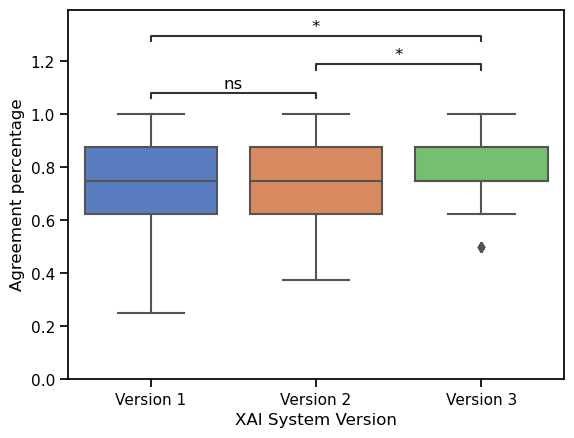

In [70]:
from itertools import combinations
from statannotations.Annotator import Annotator

values = ["basic", "salient", "explanations"]
pairs = list(combinations(values, 2))

plot_params = {
  "x": "FEATURE",
  "y": "agrees-with-ai",
  "data": df,
  "palette": "muted",
  "order": values,
}

with sns.plotting_context('notebook'):
    ax = sns.boxplot()

    sns.boxplot(**plot_params).set(xlabel='XAI System Version', ylabel='Agreement percentage')

    ax.set_ylim([0, 1])
    ax.set_xticklabels(["Version 1", "Version 2", "Version 3"])

    p_values = []
    for pair in pairs:
        p_val = posthoc[(
            (posthoc["A"] == pair[0]) & (posthoc["B"] == pair[1]) | 
            (posthoc["B"] == pair[0]) & (posthoc["A"] == pair[1]))]["p-corr"]

        p_values.append(p_val.values[0])

    # Add annotations
    annotator = Annotator(ax, pairs, **plot_params)
    annotator.set_pvalues_and_annotate(p_values,)

    plt.show()

### Switch percentage (v1 vs v2 vs v3)

In [71]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, "switched-to-ai", print_results=False);

In [72]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,10.108654,0.006382


In [73]:
print_kruskal_latex(kruskal)

(H=$10.11$, $p$-value=$<.01$)


In [74]:
highlight(posthoc)

,A,B,p-corr,cohen
0,basic,salient,0.205844,0.217698
1,basic,explanations,0.205844,-0.181541
2,salient,explanations,0.004449,-0.405033


In [75]:
format_posthoc(posthoc,
                caption="Pairwise comparison of XAI Versions for Switch percentage using Dunn's tests",
                label="switched_percentage_comp",
                between_col_mapping={
                    "basic": "Baseline (V1)",
                    "salient": "Salient features (V2)",
                    "explanations": "Free-text (V3)",
                },
                column_a_name="XAI Version A",
                column_b_name="XAI Version B")

\begin{table}
\centering
\caption{Pairwise comparison of XAI Versions for Switch percentage using Dunn's tests ($p$-values corrected with the Holm-Bonferroni method)}
\label{tab:switched_percentage_comp}
\begin{tabular}{llrr}
\toprule
        XAI Version A &         XAI Version B &    $p$ &  Cohen's $d$ \\
\midrule
        Baseline (V1) & Salient features (V2) &  $.21$ &         0.22 \\
        Baseline (V1) &        Free-text (V3) &  $.21$ &        -0.18 \\
Salient features (V2) &        Free-text (V3) & $<.01$ &        -0.41 \\
\bottomrule
\end{tabular}
\end{table}



In [76]:
stats

,count,mean,std
FEATURE,,,
basic,133.0,0.223684,0.178809
explanations,133.0,0.256579,0.183554
salient,140.0,0.186607,0.161836


### AI-preference (v1 vs v2 vs v3)

In [77]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, "ai-preference", print_results=False);

In [78]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,18.061552,0.000120


In [79]:
print_kruskal_latex(kruskal)

(H=$18.06$, $p$-value=$<.01$)


In [80]:
highlight(posthoc)

,A,B,p-corr,cohen
0,basic,salient,0.143849,0.160694
1,basic,explanations,0.013823,-0.326000
2,salient,explanations,0.000081,-0.484023


In [81]:
format_posthoc(posthoc,
                caption="Pairwise comparison of XAI Versions for AI Preference using Dunn's tests",
                label="ai_preference_comp",
                between_col_mapping={
                    "basic": "Baseline (V1)",
                    "salient": "Salient features (V2)",
                    "explanations": "Free-text (V3)",
                },
                column_a_name="XAI Version A",
                column_b_name="XAI Version B")

\begin{table}
\centering
\caption{Pairwise comparison of XAI Versions for AI Preference using Dunn's tests ($p$-values corrected with the Holm-Bonferroni method)}
\label{tab:ai_preference_comp}
\begin{tabular}{llrr}
\toprule
        XAI Version A &         XAI Version B &    $p$ &  Cohen's $d$ \\
\midrule
        Baseline (V1) & Salient features (V2) &  $.14$ &         0.16 \\
        Baseline (V1) &        Free-text (V3) &  $.01$ &        -0.33 \\
Salient features (V2) &        Free-text (V3) & $<.01$ &        -0.48 \\
\bottomrule
\end{tabular}
\end{table}



In [82]:
stats

,count,mean,std
FEATURE,,,
basic,133.0,0.509299,0.205499
explanations,133.0,0.576165,0.204720
salient,140.0,0.475976,0.209125


In [83]:
pg.cronbach_alpha(df[["agrees-with-ai", "switched-to-ai", "ai-preference"]])

(0.8186625030487245, array([0.786, 0.847]))

As the three metrics aim to measure similar concepts, we calculate Cronbach's alpha to determine if the metrics are consistent. The Cronbach's alpha is 0.818663, which indicates that the metrics are consistent.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

basic vs. salient: Mann-Whitney-Wilcoxon test two-sided, P_val:1.255e-01 U_stat=1.031e+04
salient vs. explanations: Mann-Whitney-Wilcoxon test two-sided, P_val:3.761e-05 U_stat=6.622e+03
basic vs. explanations: Mann-Whitney-Wilcoxon test two-sided, P_val:5.545e-03 U_stat=7.104e+03


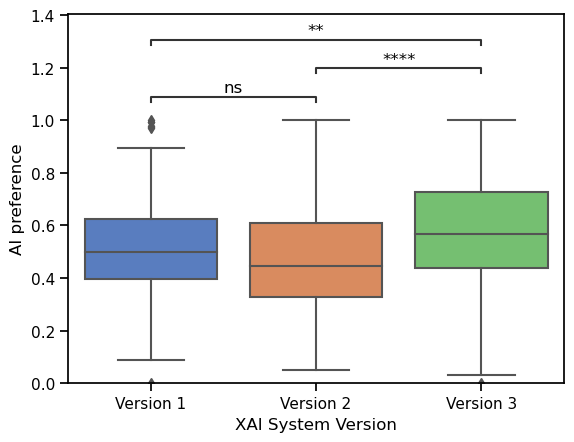

In [84]:
from itertools import combinations
from statannotations.Annotator import Annotator

values = ["basic", "salient", "explanations"]
pairs = list(combinations(values, 2))

plot_params = {
  "x": "FEATURE",
  "y": "ai-preference",
  "data": df,
  "palette": "muted",
  "order": values,
}

with sns.plotting_context('notebook'):
    ax = sns.boxplot()

    sns.boxplot(**plot_params).set(xlabel='XAI System Version', ylabel='AI preference')

    ax.set_ylim([0, 1])
    ax.set_xticklabels(["Version 1", "Version 2", "Version 3"])

    

    # Add annotations
    annotator = Annotator(ax, pairs, **plot_params)
    annotator.configure(test='Mann-Whitney')
    annotator.apply_test().annotate()

    plt.show()

## Effects of mistakes of the system

The experiment was designed to intentionally include mistakes of the AI system. We want to investigate if the participants are able to detect these mistakes, if they are willing to adjust their judgments to match the AI system and how they rate the AI-system when looking at the mistakes.

Both types of mistakes of binary classification are included in the experiment:
- **False positive**: the AI system predicts a news item to be fake, while it is actually truthful (newsitem 14)
- **False negative**: the AI system predicts a news item to be truthful, while it is actually fake (newsitem 13)

In [85]:
def get_mistake_type(row):
  if (row["is_fake_news"] == False) & (row["is_fake_news_pred"] == True):
    return "FP"
  elif (row["is_fake_news"] == True) & (row["is_fake_news_pred"] == False):
    return "FN"
  elif row["is_fake_news"]:
    return "TP"
  else:
    return "TN"

newsitems["is_mistake"] = newsitems["is_fake_news"] != newsitems["is_fake_news_pred"]
newsitems["mistake_type"] = newsitems.apply(get_mistake_type, axis=1)

In [86]:
def get_newsitem_cetagory(row):
    # assign clearly true, rather fake, clearly fake, or falsely labelled to each newsitem
    if row["is_mistake"] == True:
        return "falsely labelled"
    elif row["truthfulness"] < 25:
        return "clearly fake"
    elif row["truthfulness"] < 50:
        return "rather fake"
    elif row["truthfulness"] < 75:
        return "rather true"
    else:
        return "clearly true"
    
newsitems["newsitem_category"] = newsitems.apply(get_newsitem_cetagory, axis=1)

In [87]:
pd.set_option('display.max_colwidth', 200)

newsitems[(newsitems["id"] == 13) | (newsitems["id"] == 14)][[
    "title", "subtitle", "content", 
    "truthfulness", "is_fake_news", "is_fake_news_pred", 
    "is_mistake", "mistake_type"]
]

,title,subtitle,content,truthfulness,is_fake_news,is_fake_news_pred,is_mistake,mistake_type
13,JOE BIDEN SAYS BIBLE BELIEVING CHRISTIANS VIOLATE LGBT RIGHTS BY SIMPLY EXISTING,"In too many places, Joe Biden said today, LGBT community members face violence with impunity, mistreatment by police, the denial of healthcare, or religious condemnation and social isolation....\n",Vice President Joe Biden say today that the rights of the LGBT people are violated by “religious condemnation”. He is directly referring to Bible verses. The Progressive Liberals are well aware th...,97,True,False,True,FN
14,"Boys need to talk more about feelings and fight inequality, report says",The Global Boyhood Initiative aims to enable adults to raise boys to become men who embrace healthy masculinity\r\n,"Boys should be encouraged to ignore gender stereotypes and share their emotions, according to the team behind a new UK initiative aimed at encouraging them to talk about their feelings and speak o...",10,False,True,True,FP


In [88]:
newsitem_eval_df = pd.DataFrame()

for i in range(7, 15):
    newsitem_cols = [
                     f"newsitem.{i}.system-evaluation.classified-correctly",
                     f"newsitem.{i}.system-evaluation.explanations-comprehensible-and-help-assess",
                     f"newsitem.{i}.system-evaluation.indications-useful",
                     f"newsitem.{i}.system-evaluation.understand-what-system-does",
                     f"newsitem.{i}.system-evaluation.xai-features-useful",
                     f"newsitem.{i}.rating-before-correct",
                     f"newsitem.{i}.rating-after-correct",
                     f"newsitem.{i}.agrees-with-ai",
                     f"newsitem.{i}.switched-to-ai",
                     f"newsitem.{i}.ai-preference",
                     "FEATURE"
                    ]
    newsitem_eval_df = pd.concat([newsitem_eval_df, df[newsitem_cols].rename(columns={col: col.split(".")[-1] for col in newsitem_cols}).assign(newsitem=i)])

# make "newsitem" the first column
cols = newsitem_eval_df.columns.tolist()
cols = cols[-2:] + cols[:-2]
newsitem_eval_df = newsitem_eval_df[cols]

In [89]:
# join newsitem_eval_df with newsitems to get the "is_mistake" column
newsitem_eval_df = newsitem_eval_df.merge(
  newsitems[["id", "is_fake_news", "is_mistake", "mistake_type", "newsitem_category"]], 
  left_on="newsitem", 
  right_on="id").drop(columns=["id"])

Measures:
- on newsitem level: accuracy, change in accuracy, agreement percentage, switch percentage
- on single rating level: ai-preference, local evaluation metrics

In [90]:
newsitem_eval_df.sample(5, random_state=42)

,FEATURE,newsitem,classified-correctly,explanations-comprehensible-and-help-assess,indications-useful,understand-what-system-does,xai-features-useful,rating-before-correct,rating-after-correct,agrees-with-ai,switched-to-ai,ai-preference,is_fake_news,is_mistake,mistake_type,newsitem_category
1905,explanations,11,7.0,7.0,7.0,6.0,7.0,False,True,True,True,0.888889,True,False,TP,clearly fake
1815,salient,11,6.0,6.0,6.0,6.0,6.0,True,True,True,False,0.000000,True,False,TP,clearly fake
2004,explanations,11,7.0,7.0,7.0,6.0,7.0,True,True,True,False,0.833333,True,False,TP,clearly fake
321,explanations,7,7.0,7.0,7.0,7.0,7.0,True,True,True,False,1.000000,False,False,TN,clearly true
2847,basic,14,2.0,1.0,3.0,4.0,2.0,True,False,True,True,0.173913,False,True,FP,falsely labelled


### Accuracy on newsitems before and after seeing the AI score

In [91]:
# calculate average performance over newsitems
performance_df = newsitem_eval_df.groupby(["newsitem_category"])[["rating-before-correct", "rating-after-correct"]].mean().reset_index()

In [92]:
performance_df["accuracy-diff"] = performance_df["rating-after-correct"] - performance_df["rating-before-correct"]

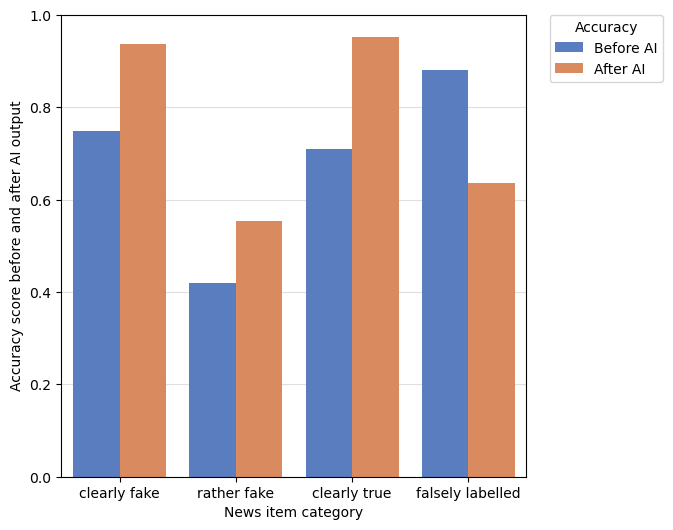

In [93]:
# transform data to long format
data = performance_df[["newsitem_category", "rating-before-correct", "rating-after-correct"]].melt(id_vars=["newsitem_category"], var_name="measure", value_name="rating")

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x="newsitem_category", y="rating", 
  hue="measure", 
  data=data, 
  ax=ax, 
  palette="muted",
  order=["clearly fake", "rather fake", "clearly true", "falsely labelled"]
  )

# rename legend labels
handles, labels = ax.get_legend_handles_labels()
# put legend outside of plot
ax.legend(handles=handles, labels=["Before AI", "After AI"], title="Accuracy", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


ax.set_ylabel("Accuracy score before and after AI output")
ax.set_xlabel("News item category")

ax.set_axisbelow(True)
ax.yaxis.grid(True, which='major', color='grey', alpha=.25)


In [94]:
performance_df

,newsitem_category,rating-before-correct,rating-after-correct,accuracy-diff
0,clearly fake,0.747947,0.938424,0.190476
1,clearly true,0.710591,0.953202,0.242611
2,falsely labelled,0.881773,0.635468,-0.246305
3,rather fake,0.418719,0.554187,0.135468


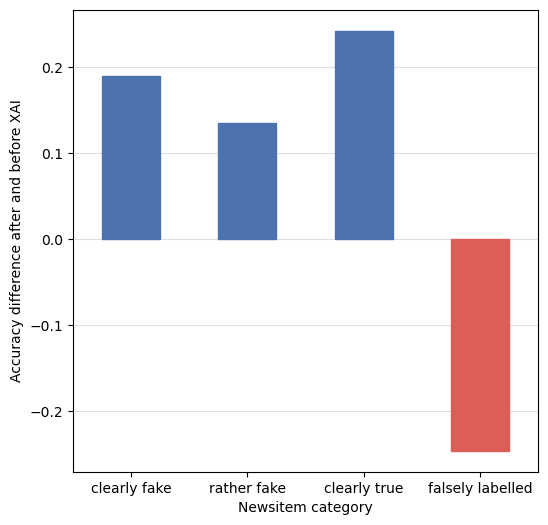

In [95]:
blue = "#4C72B0"
red = "#DB5F57"

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x="newsitem_category", y="accuracy-diff", data=performance_df, ax=ax, palette="muted", width=.5,
            order=["clearly fake", "rather fake", "clearly true", "falsely labelled"])
ax.set_ylabel("Accuracy difference after and before XAI")
ax.set_xlabel("Newsitem category")

# set the colors of the bars based on their value
for i, bar in enumerate(ax.patches):
  if bar.get_height() > 0:
    bar.set_color(blue)
  else:
    bar.set_color(red)

ax.set_axisbelow(True)
ax.yaxis.grid(True, which='major', color='grey', alpha=.25)


### AI-preference on newsitems

In [96]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(newsitem_eval_df, dv="ai-preference", between="newsitem_category", print_results=False)

In [97]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,newsitem_category,3,314.548342,0.000000


In [98]:
print_kruskal_latex(kruskal)

(H=$314.55$, $p$-value=$<.01$)


In [99]:
highlight(posthoc)

,A,B,p-corr,cohen
0,clearly true,rather fake,0.000000,0.371953
1,clearly true,clearly fake,0.000000,0.282842
2,clearly true,falsely labelled,0.000000,1.050107
3,rather fake,clearly fake,0.274960,-0.056910
4,rather fake,falsely labelled,0.000000,0.645009
5,clearly fake,falsely labelled,0.000000,0.661657


In [100]:
format_posthoc(posthoc,
                caption="Pairwise comparison of news item categories for AI Preference using Dunn's tests",
                label="ai_pref_news_cat",
                between_col_mapping={
                    "clearly fake": "clearly fake",
                    "rather fake": "rather fake",
                    "clearly true": "clearly true",
                    "falsely labelled": "falsely labelled",
                },
                column_a_name="Category A",
                column_b_name="Category B")

\begin{table}
\centering
\caption{Pairwise comparison of news item categories for AI Preference using Dunn's tests ($p$-values corrected with the Holm-Bonferroni method)}
\label{tab:ai_pref_news_cat}
\begin{tabular}{llrr}
\toprule
  Category A &       Category B &    $p$ &  Cohen's $d$ \\
\midrule
clearly true &      rather fake & $<.01$ &         0.37 \\
clearly true &     clearly fake & $<.01$ &         0.28 \\
clearly true & falsely labelled & $<.01$ &         1.05 \\
 rather fake &     clearly fake &  $.27$ &        -0.06 \\
 rather fake & falsely labelled & $<.01$ &         0.65 \\
clearly fake & falsely labelled & $<.01$ &         0.66 \\
\bottomrule
\end{tabular}
\end{table}



In [101]:
stats

,count,mean,std
newsitem_category,,,
clearly fake,1218.0,0.560104,0.411773
clearly true,812.0,0.669083,0.341741
falsely labelled,812.0,0.301055,0.358981
rather fake,406.0,0.537114,0.379602


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

clearly fake vs. rather fake: Custom statistical test, P_val:2.750e-01
rather fake vs. clearly true: Custom statistical test, P_val:2.876e-07
clearly true vs. falsely labelled: Custom statistical test, P_val:3.337e-65
clearly fake vs. clearly true: Custom statistical test, P_val:4.122e-08
rather fake vs. falsely labelled: Custom statistical test, P_val:8.658e-18
clearly fake vs. falsely labelled: Custom statistical test, P_val:1.297e-38


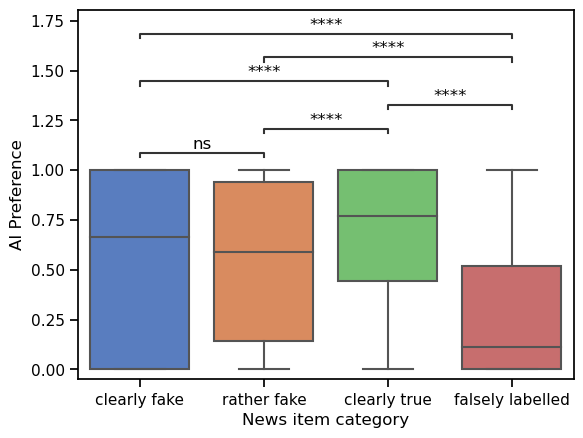

In [102]:
from itertools import combinations
from statannotations.Annotator import Annotator

values = ["clearly fake", "rather fake", "clearly true", "falsely labelled"]
pairs = list(combinations(values, 2))

plot_params = {
  "x": "newsitem_category",
  "y": "ai-preference",
  "data": newsitem_eval_df,
  "palette": "muted",
  "order": ["clearly fake", "rather fake", "clearly true", "falsely labelled"]
}

with sns.plotting_context('notebook'):
    ax = sns.boxplot()

    sns.boxplot(**plot_params).set(xlabel='News item category', ylabel='AI Preference')

    p_values = []
    for pair in pairs:
        p_val = posthoc[(
            (posthoc["A"] == pair[0]) & (posthoc["B"] == pair[1]) | 
            (posthoc["B"] == pair[0]) & (posthoc["A"] == pair[1]))]["p-corr"]

        p_values.append(p_val.values[0])

    # Add annotations
    annotator = Annotator(ax, pairs, **plot_params)
    annotator.set_pvalues_and_annotate(p_values,)

    plt.show()

### Local evaluation of the system's behavior

In [103]:
local_eval_cols = [
    'classified-correctly', # The AI-System classified the news items correctly
    'explanations-comprehensible-and-help-assess', # The presented explanations are comprehensible and help me with assessing the news articles
    'indications-useful', # The indications given by the AI-System are useful to assess the truthfulness of the news article
    'understand-what-system-does', # I understand what the AI-System does
    'xai-features-useful', # The explainability features presented are useful to assess the truthfulness of the news article
]

In [104]:
trust_cols = [
  'understand-what-system-does',
  'classified-correctly'
]

usefulness_cols = [
  'xai-features-useful',
  'indications-useful'
]

understandability_cols = [
  'explanations-comprehensible-and-help-assess',
]

In [105]:
newsitem_eval_df["trust"] = newsitem_eval_df[trust_cols].mean(axis=1)
newsitem_eval_df["usefulness"] = newsitem_eval_df[usefulness_cols].mean(axis=1)
newsitem_eval_df["understandability"] = newsitem_eval_df[understandability_cols].mean(axis=1)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

clearly fake vs. rather fake: Custom statistical test, P_val:3.074e-06
rather fake vs. clearly true: Custom statistical test, P_val:1.226e-05
clearly true vs. falsely labelled: Custom statistical test, P_val:2.092e-90
clearly fake vs. clearly true: Custom statistical test, P_val:9.087e-01
rather fake vs. falsely labelled: Custom statistical test, P_val:1.329e-32
clearly fake vs. falsely labelled: Custom statistical test, P_val:2.859e-109


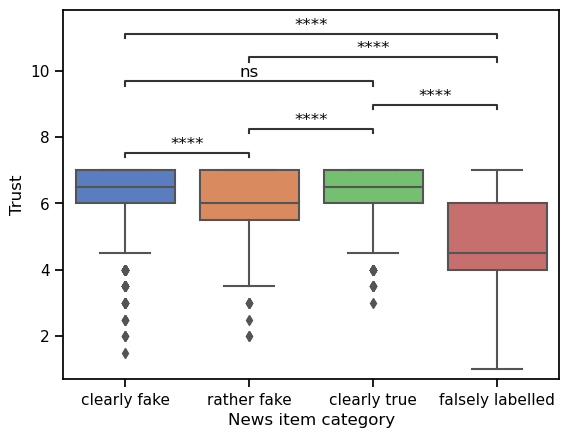

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

clearly fake vs. rather fake: Custom statistical test, P_val:9.518e-03
rather fake vs. clearly true: Custom statistical test, P_val:2.145e-02
clearly true vs. falsely labelled: Custom statistical test, P_val:4.774e-41
clearly fake vs. clearly true: Custom statistical test, P_val:7.574e-01
rather fake vs. falsely labelled: Custom statistical test, P_val:7.528e-17
clearly fake vs. falsely labelled: Custom statistical test, P_val:5.522e-51


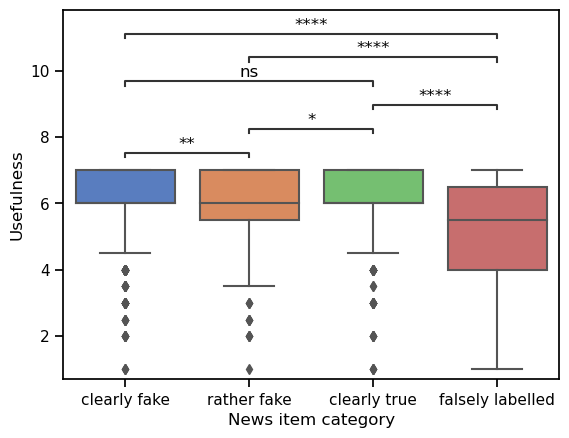

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

clearly fake vs. rather fake: Custom statistical test, P_val:7.213e-03
rather fake vs. clearly true: Custom statistical test, P_val:5.732e-02
clearly true vs. falsely labelled: Custom statistical test, P_val:5.777e-29
clearly fake vs. clearly true: Custom statistical test, P_val:3.663e-01
rather fake vs. falsely labelled: Custom statistical test, P_val:7.292e-12
clearly fake vs. falsely labelled: Custom statistical test, P_val:1.500e-39


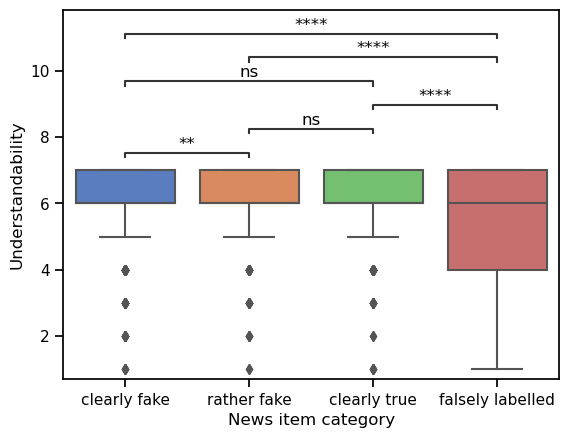

In [106]:
from itertools import combinations
from statannotations.Annotator import Annotator

for local_eval_col in ["trust", "usefulness", "understandability"]:

    values = ["clearly fake", "rather fake", "clearly true", "falsely labelled"]
    pairs = list(combinations(values, 2))

    plot_params = {
      "x": "newsitem_category",
      "y": local_eval_col,
      "data": newsitem_eval_df,
      "palette": "muted",
      "order": values
    }

    kruskal, posthoc, stats = perform_kruskal_with_posthoc(newsitem_eval_df, dv=local_eval_col, between="newsitem_category", print_results=False)

    with sns.plotting_context('notebook'):
        ax = sns.boxplot()

        ylabel = local_eval_col.replace("-", " ").capitalize()
        sns.boxplot(**plot_params).set(xlabel='News item category', ylabel=ylabel)

        p_values = []
        for pair in pairs:
            p_val = posthoc[(
                (posthoc["A"] == pair[0]) & (posthoc["B"] == pair[1]) | 
                (posthoc["B"] == pair[0]) & (posthoc["A"] == pair[1]))]["p-corr"]

            p_values.append(p_val.values[0])

        # Add annotations
        annotator = Annotator(ax, pairs, **plot_params)
        annotator.set_pvalues_and_annotate(p_values)

        plt.show()

In [107]:
summary_data = []

for col in ["trust", "usefulness", "understandability"]:
    kruskal, posthoc, stats = perform_kruskal_with_posthoc(newsitem_eval_df, dv=col, between="newsitem_category", print_results=False)
    summary_data.append({
        "measure": col,
        "H": kruskal["H"].values[0],
        "p-unc": kruskal["p-unc"].values[0],
    })

    print(col)
    print_kruskal_latex(kruskal)
    print(format_posthoc(posthoc,
                caption=f"Pairwise comparison of news item categories for {col} using Dunn's tests",
                label=f"{col}_mistakes",
                between_col_mapping={
                    "clearly fake": "clearly fake",
                    "rather fake": "rather fake",
                    "clearly true": "clearly true",
                    "falsely labelled": "falsely labelled",
                },
                column_a_name="Category A",
                column_b_name="Category B"
    ))

summary_df = pd.DataFrame(summary_data)
highlight(summary_df)

trust
(H=$589.02$, $p$-value=$<.01$)
\begin{table}
\centering
\caption{Pairwise comparison of news item categories for trust using Dunn's tests ($p$-values corrected with the Holm-Bonferroni method)}
\label{tab:trust_mistakes}
\begin{tabular}{llrr}
\toprule
  Category A &       Category B &    $p$ &  Cohen's $d$ \\
\midrule
clearly true &      rather fake & $<.01$ &         0.35 \\
clearly true &     clearly fake &  $.91$ &         0.04 \\
clearly true & falsely labelled & $<.01$ &         1.24 \\
 rather fake &     clearly fake & $<.01$ &        -0.28 \\
 rather fake & falsely labelled & $<.01$ &         0.87 \\
clearly fake & falsely labelled & $<.01$ &         1.21 \\
\bottomrule
\end{tabular}
\end{table}

None
usefulness
(H=$268.78$, $p$-value=$<.01$)
\begin{table}
\centering
\caption{Pairwise comparison of news item categories for usefulness using Dunn's tests ($p$-values corrected with the Holm-Bonferroni method)}
\label{tab:usefulness_mistakes}
\begin{tabular}{llrr}
\toprule
  C

,measure,H,p-unc
0,trust,589.023895,0.000000
1,usefulness,268.777979,0.000000
2,understandability,199.967566,0.000000


### Which participants can detect the mistakes of the system?

The ability to detect mistakes of the system is measured using two metrics:
- **AI preference for mistakes**: average AI-preference of the participants on the two newsitems where the AI made a mistake (the lower the AI-preference, the better the participant is able to detect mistakes)
- **Number of corrected mistakes**: the number of newsitems where the participant's second rating corrects the mistake of the AI (the higher the number, the better the participant is able to detect the mistakes)

In [108]:
df["mistake-ai-preference"] = np.mean([
    df["newsitem.13.ai-preference"], 
    df["newsitem.14.ai-preference"]
], axis=0)

In [109]:
df["fixed-mistakes-count"] = 2 - np.sum([
    df["newsitem.13.agrees-with-ai"],
    df["newsitem.14.agrees-with-ai"]
], axis=0)

In [110]:
relevant_demographics_cols = [
    'demographics.age',
    'demographics.gender',
    'demographics.education',
    'demographics.employment',
    'demographics.income'
]

#### Demographics

In [111]:
def summary_to_latex(summary_df, caption, label):
    data = summary_df.copy()

    data["Source"] = data["Source"].apply(lambda x: x.split(".")[1].capitalize())

    data = data.drop(columns=["ddof1"]).rename(columns={
        "Source": "Demographic variable",
        "H": "Test statistic",
        "p-unc": "$p$",
    })

    data["$p$"] = data["$p$"].apply(lambda x: "$<.01$" if x < 0.01 else f"${x:.2f}$".replace('0.','.'))

    return data.to_latex(
        index=False, 
        escape=False, 
        na_rep="", 
        float_format="%.2f", 
        caption=caption, 
        label=f"tab:{label}",
    )

In [112]:
summary_df = pd.DataFrame()

for demo_col in relevant_demographics_cols:
    kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, dv="mistake-ai-preference", between=demo_col, print_results=False)

    # reset index of kruskal dataframe
    kruskal = kruskal.reset_index(drop=True)

    summary_df = pd.concat([summary_df, kruskal])
    
summary_df = summary_df.reset_index(drop=True)

highlight(summary_df)


,Source,ddof1,H,p-unc
0,demographics.age,5,0.814808,0.976079
1,demographics.gender,2,1.576807,0.454570
2,demographics.education,4,8.730502,0.068200
3,demographics.employment,7,4.706767,0.695697
4,demographics.income,6,11.850651,0.065385


In [113]:
print(summary_to_latex(
    summary_df,
    caption="Results from Kruskal-Wallis tests for the effect of demographics on the AI Preference for mistakes",
    label="ai_pref_mistakes_demographics"))

\begin{table}
\centering
\caption{Results from Kruskal-Wallis tests for the effect of demographics on the AI Preference for mistakes}
\label{tab:ai_pref_mistakes_demographics}
\begin{tabular}{lrl}
\toprule
Demographic variable &  Test statistic &   $p$ \\
\midrule
                 Age &            0.81 & $.98$ \\
              Gender &            1.58 & $.45$ \\
           Education &            8.73 & $.07$ \\
          Employment &            4.71 & $.70$ \\
              Income &           11.85 & $.07$ \\
\bottomrule
\end{tabular}
\end{table}



In [114]:
summary_df = pd.DataFrame()

for demo_col in relevant_demographics_cols:
    kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, dv="fixed-mistakes-count", between=demo_col, print_results=False)

    # reset index of kruskal dataframe
    kruskal = kruskal.reset_index(drop=True)

    summary_df = pd.concat([summary_df, kruskal])
    
summary_df = summary_df.reset_index(drop=True)

highlight(summary_df)

,Source,ddof1,H,p-unc
0,demographics.age,5,0.610386,0.987523
1,demographics.gender,2,0.528382,0.767827
2,demographics.education,4,8.611683,0.071573
3,demographics.employment,7,5.358297,0.616326
4,demographics.income,6,11.502886,0.074023


In [115]:
print(summary_to_latex(
    summary_df,
    caption="Results from Kruskal-Wallis tests for the effect of demographics on the Number of corrected mistakes",
    label="corrected_mistakes_demographics"))

\begin{table}
\centering
\caption{Results from Kruskal-Wallis tests for the effect of demographics on the Number of corrected mistakes}
\label{tab:corrected_mistakes_demographics}
\begin{tabular}{lrl}
\toprule
Demographic variable &  Test statistic &   $p$ \\
\midrule
                 Age &            0.61 & $.99$ \\
              Gender &            0.53 & $.77$ \\
           Education &            8.61 & $.07$ \\
          Employment &            5.36 & $.62$ \\
              Income &           11.50 & $.07$ \\
\bottomrule
\end{tabular}
\end{table}



There are no significant differences between demographic groups in the ability to detect mistakes of the system (p > 0.05). However, education level and income level show a trend towards significance (p = 0.068200 and p = 0.065385 respectively). Higher education level and higher income level are associated with a higher ability to detect mistakes of the system.

##### Education

In [116]:
def print_spearman_latex(data):
    print(f"($\\rho={data['r'].values[0]:.2f}$, $p={data['p-val'].values[0]:.2f}$, $n={data['n'].values[0]}$)")

In [117]:
df.groupby("demographics.education")["fixed-mistakes-count"].describe()[["count", "mean", "std"]]

,count,mean,std
demographics.education,,,
high-school,161.0,1.186335,0.852973
no-degree,11.0,0.818182,0.873863
secondary,9.0,1.000000,1.000000
university,220.0,1.359091,0.766394
upper-secondary,5.0,1.600000,0.894427


In [118]:
df["education-level"] = df["demographics.education"].map({
    "no-degree": 0,
    "secondary": 1,
    "upper-secondary": 2,
    "high-school": 3,
    "university": 4
})

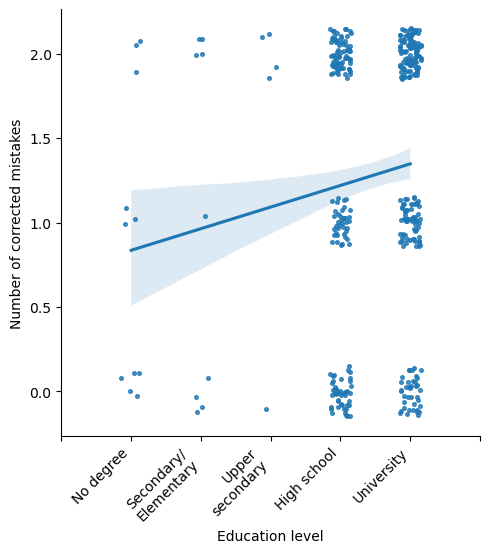

In [119]:
fig = sns.lmplot(
    data=df, 
    x="education-level", 
    y="fixed-mistakes-count",
    x_jitter=.15, y_jitter=.15,
    scatter_kws={"s":7}, legend=False)

ticks = [
    "",
    "No degree",
    "Secondary/\nElementary",
    "Upper\nsecondary",
    "High school",
    "University",
    ""
]

fig.set_xticklabels(ticks, rotation=45, ha="right")

fig.set_axis_labels("Education level", "Number of corrected mistakes");

In [120]:
spearman = pg.corr(x=df["education-level"], y=df["fixed-mistakes-count"], method="spearman")
display(highlight(spearman))
print_spearman_latex(spearman)

,n,r,CI95%,p-val,power
spearman,406,0.113519,[0.02 0.21],0.022155,0.629785


($\rho=0.11$, $p=0.02$, $n=406$)


##### Income

In [121]:
df.groupby("demographics.income")["fixed-mistakes-count"].describe()[["count", "mean", "std"]]

,count,mean,std
demographics.income,,,
20000-34999-usd,72.0,1.236111,0.847416
35000-49999-usd,44.0,1.136364,0.851562
50000-74999-usd,83.0,1.144578,0.798360
75000-99999-usd,49.0,1.408163,0.733666
less-than-20000-usd,58.0,1.155172,0.894461
no-answer,45.0,1.422222,0.753443
over-100000-usd,55.0,1.490909,0.766733


In [122]:
df["income-level"] = df["demographics.income"].map({
    "less-than-20000-usd": 0,
    "20000-34999-usd": 1,
    "35000-49999-usd": 2,
    "50000-74999-usd": 3,
    "75000-99999-usd": 4,
    "over-100000-usd": 5,
    # no-answer is mapped to NaN, which is ignored by seaborn
})

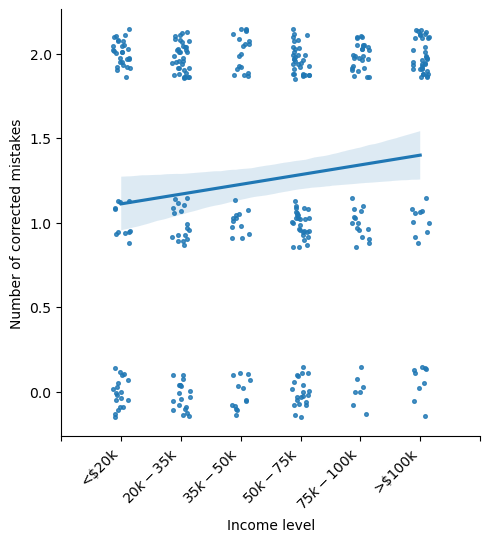

In [123]:
fig = sns.lmplot(
    data=df, 
    x="income-level", 
    y="fixed-mistakes-count",
    x_jitter=.15, y_jitter=.15,
    scatter_kws={"s":7}, legend=False)

# set xticks
ticks = [
    "", # add an empty label for the extra tick
    "<$20k",
    "$20k-$35k",
    "$35k-$50k",
    "$50k-$75k",
    "$75k-$100k",
    ">$100k",
    ""  # add another empty label for the extra tick
]

fig.set_xticklabels(ticks, rotation=45, ha="right")


fig.set_axis_labels("Income level", "Number of corrected mistakes");

In [124]:
spearman = pg.corr(x=df["income-level"], y=df["fixed-mistakes-count"], method="spearman")
display(highlight(spearman))
print_spearman_latex(spearman)

,n,r,CI95%,p-val,power
spearman,361,0.110615,[0.01 0.21],0.035655,0.557311


($\rho=0.11$, $p=0.04$, $n=361$)


#### Information literacy

In [125]:
information_literacy_cols = [col for col in df.columns if "information-literacy." in col]
pg.cronbach_alpha(df[information_literacy_cols])

(0.9001577165376676, array([0.885, 0.914]))

In [126]:
df["information-literacy"] = np.sum(df[information_literacy_cols], axis=1)

In [127]:
spearman = pg.corr(x=df["information-literacy"], y=df["fixed-mistakes-count"], method="spearman")
display(highlight(spearman))
print_spearman_latex(spearman)

,n,r,CI95%,p-val,power
spearman,406,0.048453,[-0.05 0.15],0.330121,0.163822


($\rho=0.05$, $p=0.33$, $n=406$)


In [128]:
spearman = pg.corr(x=df["information-literacy"], y=df["mistake-ai-preference"], method="spearman")
display(highlight(spearman))
print_spearman_latex(spearman)

,n,r,CI95%,p-val,power
spearman,406,-0.074798,[-0.17 0.02],0.132429,0.325147


($\rho=-0.07$, $p=0.13$, $n=406$)


Information literacy does not seem to play a role in detecting the mistakes. Moderate correlation between accuracy without AI ratings and ability to detect mistakes.

### Detecting mistakes among groups

#### Number of corrected mistakes

In [129]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, dv="fixed-mistakes-count", between="FEATURE", print_results=False)

In [130]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,2.966495,0.226900


In [131]:
print_kruskal_latex(kruskal)

(H=$2.97$, $p$-value=$.23$)


#### AI-preference at mistakes

In [132]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, dv="mistake-ai-preference", between="FEATURE", print_results=False)

In [133]:
highlight(kruskal)

,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,6.496020,0.038851


In [134]:
print_kruskal_latex(kruskal)

(H=$6.50$, $p$-value=$.04$)


In [135]:
highlight(posthoc)

,A,B,p-corr,cohen
0,basic,salient,0.519330,0.043064
1,basic,explanations,0.143685,-0.235669
2,salient,explanations,0.040826,-0.274848


In [136]:
format_posthoc(posthoc,
                caption="Pairwise comparison of XAI Versions for AI Preference for mistakes using Dunn's tests",
                label="ai_pref_mistakes_comp",
                between_col_mapping={
                    "basic": "Baseline (V1)",
                    "salient": "Salient features (V2)",
                    "explanations": "Free-text (V3)",
                },
                column_a_name="XAI Version A",
                column_b_name="XAI Version B")

\begin{table}
\centering
\caption{Pairwise comparison of XAI Versions for AI Preference for mistakes using Dunn's tests ($p$-values corrected with the Holm-Bonferroni method)}
\label{tab:ai_pref_mistakes_comp}
\begin{tabular}{llrr}
\toprule
        XAI Version A &         XAI Version B &   $p$ &  Cohen's $d$ \\
\midrule
        Baseline (V1) & Salient features (V2) & $.52$ &         0.04 \\
        Baseline (V1) &        Free-text (V3) & $.14$ &        -0.24 \\
Salient features (V2) &        Free-text (V3) & $.04$ &        -0.27 \\
\bottomrule
\end{tabular}
\end{table}



In [137]:
stats

,count,mean,std
FEATURE,,,
basic,133.0,0.281200,0.297582
explanations,133.0,0.355423,0.331407
salient,140.0,0.268266,0.302910


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

basic vs. salient: Custom statistical test, P_val:5.193e-01
salient vs. explanations: Custom statistical test, P_val:4.083e-02
basic vs. explanations: Custom statistical test, P_val:1.437e-01


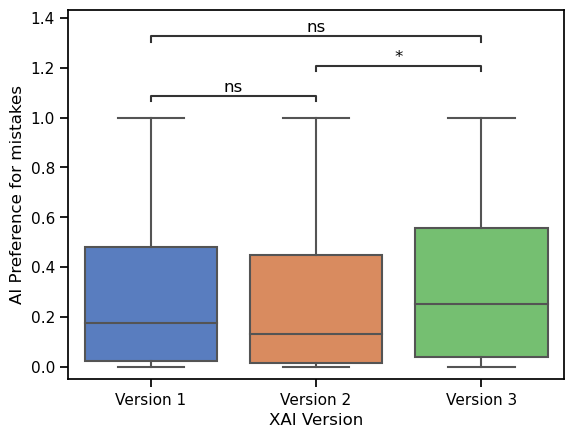

In [138]:
from statannotations.Annotator import Annotator
from itertools import combinations

values = ["basic", "salient", "explanations"]
pairs = list(combinations(values, 2))

plot_params = {
  'data': df,
  'x': 'FEATURE',
  'y': 'mistake-ai-preference',
  'palette': 'muted'
}

with sns.plotting_context('notebook'):
    ax = sns.boxplot()

    sns.boxplot(**plot_params).set(xlabel='XAI Version', ylabel='AI Preference for mistakes')

    # rename basic, salient, explanations to be Version 1, Version 2, Version 3
    ax.set_xticklabels(["Version 1", "Version 2", "Version 3"])

    p_values = []
    for pair in pairs:
        p_val = posthoc[(
            (posthoc["A"] == pair[0]) & (posthoc["B"] == pair[1]) | 
            (posthoc["B"] == pair[0]) & (posthoc["A"] == pair[1]))]["p-corr"]

        p_values.append(p_val.values[0])

    # Add annotations
    annotator = Annotator(ax, pairs, **plot_params)
    annotator.set_pvalues_and_annotate(p_values)

    plt.show()

Key takeaways:
- Participants could detect the mistakes of the system (lower local evaluation metrics, lower AI-preference)
- AI mistakes still had a negative effect on the accuracy of the participants (Human-AI accuracy for mistakes is lower than Human accuracy)
- Education level and income level are associated with a higher ability to detect mistakes of the system, but the effect is not significant
- Information literacy does not seem to play a role in detecting the mistakes

## Analysis of open questions

The questionnaire includes three open questions, one about the participants' usual criteria for judging the trustworthiness of news items (*"What criteria do you usually use to judge whether a news/article is reliable?"*) and two questions about additional information or functionality they wish to see in the system to improve it (*"What functionality would be a good addition?"*; *"What other information would you like to obtain to better assess the truthfulness of an article?"*).

In addition to reading the answers to these questions, the answers were also analyzed by determining the 50 most common words in the answers. (To count the words the base forms of the words were used, using the spaCy library.)

In [139]:
criteria_col = "ai-system-evaluation.criteria-to-judge-reliability"
add_func_col = "ai-system-evaluation.additional-functionality"
other_info_col = "ai-system-evaluation.other-information-wish"

### NLP determining lemma frequencies

In [140]:
import spacy
nlp = spacy.load("en_core_web_sm")

def lemmas_present(row, col, word_counts):
    text = row[col]
    text = str(text).lower()

    doc = nlp(text)
    lemmas = [token.lemma for token in doc if not token.is_stop and not token.is_punct and not token.text.isspace()]
    words = [nlp.vocab.strings[lemma] for lemma in lemmas]

    for word in word_counts.index:
        if word in words:
            row[word] = True
        else:
            row[word] = False

    return row

In [141]:
from collections import Counter

criteria_df = df[[criteria_col]].copy()

text = " ".join(str(val) for val in criteria_df.values)
text = text.lower()

doc = nlp(text)

# extract the tokens and count their frequency
lemmas = [token.lemma for token in doc if not token.is_stop and not token.is_punct and not token.text.isspace()]
# convert lemmas to actual words instead of ids (e.g. 10382539506755952630 -> "system")
words = [nlp.vocab.strings[lemma] for lemma in lemmas]

# count the frequency of each word
word_counts = Counter(words)
word_counts_df = pd.DataFrame.from_dict(word_counts, orient="index", columns=["count"])

word_counts_df = word_counts_df.sort_values("count", ascending=False)
word_counts_df = word_counts_df.head(50)

criteria_df = criteria_df.apply(lemmas_present, col=criteria_col, word_counts=word_counts_df, axis=1)
criteria_words = words

In [142]:
wish_df = df[[add_func_col, other_info_col]].copy()

wish_df["wish"] = wish_df[add_func_col].fillna("") + " " + wish_df[other_info_col].fillna("")
wish_df = wish_df[["wish"]]

text = " ".join(str(val) for val in wish_df.values)
text = text.lower()

doc = nlp(text)

# extract the tokens and count their frequency
lemmas = [token.lemma for token in doc if not token.is_stop and not token.is_punct and not token.text.isspace()]
# convert lemmas to actual words instead of ids (e.g. 10382539506755952630 -> "system")
words = [nlp.vocab.strings[lemma] for lemma in lemmas]

# count the frequency of each word
word_counts = Counter(words)
word_counts_df = pd.DataFrame.from_dict(word_counts, orient="index", columns=["count"])

word_counts_df = word_counts_df.sort_values("count", ascending=False)
word_counts_df = word_counts_df.head(50)

wish_df = wish_df.apply(lemmas_present, col="wish", word_counts=word_counts_df, axis=1)
wish_words = words

In [143]:
criteria_df.mean(numeric_only=True).sort_values(ascending=False)

source         0.554187
article        0.165025
information    0.110837
fact           0.096059
news           0.066502
check          0.064039
language       0.061576
come           0.061576
bias           0.056650
use            0.051724
opinion        0.049261
look           0.044335
publish        0.041872
date           0.041872
author         0.039409
grammar        0.039409
credibility    0.036946
write          0.034483
research       0.032020
reliable       0.032020
reputation     0.032020
content        0.029557
usually        0.029557
multiple       0.029557
base           0.027094
publisher      0.027094
emotional      0.027094
website        0.027094
find           0.024631
know           0.024631
knowledge      0.024631
cite           0.024631
sense          0.024631
site           0.024631
sound          0.024631
reliability    0.024631
common         0.024631
word           0.024631
trust          0.022167
emotion        0.022167
publication    0.022167
like           0

In [144]:
wish_df.mean(numeric_only=True).sort_values(ascending=False)

source          0.559113
article         0.374384
information     0.246305
ai              0.216749
link            0.152709
news            0.100985
author          0.098522
fact            0.091133
like            0.083744
check           0.081281
think           0.081281
provide         0.066502
publish         0.066502
truthfulness    0.061576
good            0.059113
date            0.056650
website         0.056650
add             0.056650
fake            0.056650
reference       0.054187
system          0.054187
sure            0.051724
know            0.051724
explanation     0.046798
rating          0.046798
actual          0.044335
true            0.039409
addition        0.039409
find            0.039409
helpful         0.039409
come            0.039409
publication     0.039409
ability         0.036946
maybe           0.036946
base            0.034483
cite            0.034483
info            0.034483
give            0.032020
need            0.032020
able            0.032020


### Wordclouds

In [145]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
  # create a grey color based on the font size
  return "hsl(210, 100%%, %d%%)" % max(25, (50 - int(font_size * 0.5)))

def generate_wordcloud(freqs):
  return WordCloud(
    width=1200, 
    height=1200, 
    background_color="white", 
    font_path="arial",
    max_words=50,
    random_state=42,
    color_func=grey_color_func,
  ).generate_from_frequencies(freqs)


#### Wordcloud for criteria to judge news items

Most common words (with occurences):
source (251)
article (82)
information (48)
fact (41)
news (31)
check (28)
language (26)
come (25)
bias (22)
use (22)


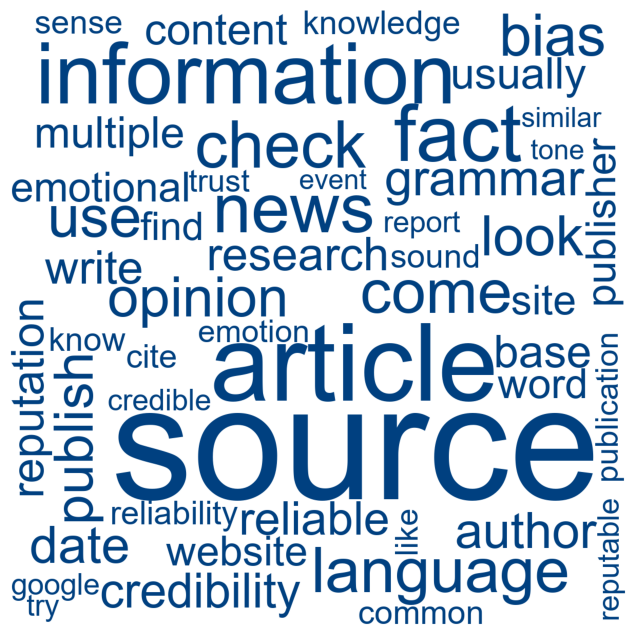

In [146]:
freqs = Counter(criteria_words)

wordcloud = generate_wordcloud(freqs)

title_text = "Most common words (with occurences):\n" + "\n".join([f"{freq[0]} ({freq[1]})" for freq in freqs.most_common(10)])
latex_title_text = "Most common words (with occurences):\\\\ " + "\\\\ ".join([f"{freq[0]} ({freq[1]})" for freq in freqs.most_common(10)])

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")

print(title_text)

plt.show()

#### Wordcloud for additional functionality and other information wish

Most common words (with occurences):
source (342)
article (226)
information (124)
ai (111)
link (77)
news (54)
author (45)
fact (43)
check (39)
think (38)


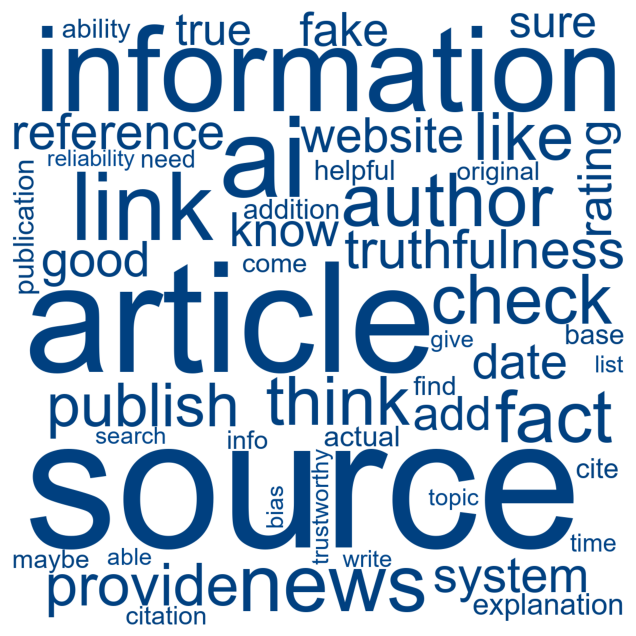

In [147]:
freqs = Counter(wish_words)

wordcloud = generate_wordcloud(freqs)

title_text = "Most common words (with occurences):\n" + "\n".join([f"{freq[0]} ({freq[1]})" for freq in freqs.most_common(10)])

# plot the WordCloud image
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")

print(title_text)

plt.show()

### Qualitative analysis of answers

Most common answers to the question *"What criteria do you usually use to judge whether a news/article is reliable?"*:

1. Source (mentioned as source, publishing source), credibility of the source, reputation of the source/publisher -- 55.42% of answers mention the term "source"
2. Author, information about the author
3. Preexisting knowledge and common sense
4. Fact-checking, using multiple sources, googling the information
5. Language usage (grammar, spelling, emotional language)
6. Bias (perceived biases, political balance, unbiased terms)
7. Objectivity (facts vs opinions)
8. Use of citations and references

In [148]:
# based on the 50 most frequent words
topic_words_dict = {
    "source": [
        "source", "article", "credibility",
        "reputation", "publish", "publisher", 
        "reliability", "reputable", "credible"
    ],
    "author": ["author", "write"],
    "knowledge": ["knowledge", "know", "common", "sense"],
    "fact check": ["fact", "check", "research", "google"],
    "language": ["language", "grammar", "emotional", "emotion", "tone"],
    "bias": ["bias"],
    "objectivity": ["opinion"],
    "citations": ["cite"]
}

topics_ratios = []

for topic, words in topic_words_dict.items():
    contain_ratio = criteria_df[words].any(axis=1).mean()

    topics_ratios.append((topic, contain_ratio))

topics_ratios = pd.DataFrame(topics_ratios, columns=["topic", "ratio"])
topics_ratios = topics_ratios.sort_values(by="ratio", ascending=False)

for topic, ratio in topics_ratios.values:
    words = topic_words_dict[topic]
    print(f"Topic '{topic}': {ratio * 100:.4f}% (contains any of the terms: {', '.join(words)})")

Topic 'source': 68.9655% (contains any of the terms: source, article, credibility, reputation, publish, publisher, reliability, reputable, credible)
Topic 'fact check': 16.0099% (contains any of the terms: fact, check, research, google)
Topic 'language': 13.7931% (contains any of the terms: language, grammar, emotional, emotion, tone)
Topic 'knowledge': 7.3892% (contains any of the terms: knowledge, know, common, sense)
Topic 'author': 7.1429% (contains any of the terms: author, write)
Topic 'bias': 5.6650% (contains any of the terms: bias)
Topic 'objectivity': 4.9261% (contains any of the terms: opinion)
Topic 'citations': 2.4631% (contains any of the terms: cite)


Answers to the question *"What functionality would be a good addition?"* and *"What other information would you like to obtain to better assess the truthfulness of an article?"* are very similar and for this reason are analyzed together. Any topic that was mentioned by multiple participants or could be interesting for future development is listed below.

1. More information about the source of the article
  - Add the actual original sources, links to the source, name of the publisher and author (not just Trustworthy/Untrustworthy source)
  - Explain why the source is trustworthy or untrustworthy
  - Show the type of source (blog, online/print newspaper, tabloid etc.)
  - Show the date of publication
2. Reference other sources of information
  - Add citations and references used by the article for each claim
  - Show a 2nd article or alternative source or alternative AI rating
  - Add a search query, a direct link to a Google search
  - Add information from human fact-checkers or fact checking websites
3. Bias
  - Provide information about bias or political balance of the source and author
4. Grammar and spelling
  - Highlight grammar and spelling mistakes
5. More information on the AI
  - Show information about who "programmed/coded" the AI
  - Show the sources used by the AI
  - Add explanations why the AI rated the article as it did (*note: analysis of this follows below*)
6. Advanced AI detection
  - Detect if images or videos are fake
  - Detect if the article is AI generated
7. Feedback feature
  - Enable users to give feedback on the AI rating
  - Noticed mistakes
8. Misc
  - Add a read-aloud functionality

In [149]:
topic_words_dict = {
  "source": [
    "source", "article", "author",
    "publish", "link", "website",
    "actual", "original"
  ],
  "references": [
    "reference", "cite", "list",
    "citation"
  ],
  "bias": [
    "bias"
  ],
  "language": [],
  "ai": [
    "ai",
    "explanation"
  ],
  "advanced ai": [],
  "feedback": [],
  "read out loud": []
}

for topic, words in topic_words_dict.items():
    if not words:
        continue

    contain_ratio = wish_df[words].any(axis=1).mean()
    print(f"Topic '{topic}': {contain_ratio * 100:.4f}% (contains any of the words: {', '.join(words)})")

Topic 'source': 76.3547% (contains any of the words: source, article, author, publish, link, website, actual, original)
Topic 'references': 12.8079% (contains any of the words: reference, cite, list, citation)
Topic 'bias': 2.9557% (contains any of the words: bias)
Topic 'ai': 24.8768% (contains any of the words: ai, explanation)


### Export open questions for labeling

For a more in depth analyses the answers were coded with two labels:
- **No addition**: the answer does not contain any information that can be used to improve the system
- **Requests explanation**: the answer requests more information on how the AI score was determined, what parameters the AI uses. Answers requesting the "original sources" of the article or "sources used by the AI" were not included in this category.

The hypothesis is that participants in the baseline (basic) group would be more likely to request an explanation or ask for any other improvement than participants in the other two groups. This hypothesis is tested with a chi-squared test.

In [150]:
df[criteria_col].sort_values(key=lambda x: x.str.len()).to_csv("./data/criteria.csv")

In [151]:
df[add_func_col].sort_values(key=lambda x: x.str.len()).to_csv("./data/additional-functionality.csv")

In [152]:
df[other_info_col].sort_values(key=lambda x: x.str.len()).to_csv("./data/other-information-wish.csv")

### Import labeled data

In [153]:
add_df = pd.read_csv("./data/additional-functionality-labeled.csv")
add_df = add_df.rename(columns={"Unnamed: 0": "response_id", 
                                "no_addition": "additional-functionality.no-addition",
                                "requests_explanation": "additional-functionality.requests-explanation",})
add_df = add_df.drop(columns=[add_func_col])

add_df["additional-functionality.no-addition"] = add_df["additional-functionality.no-addition"].astype(bool)
add_df["additional-functionality.requests-explanation"] = add_df["additional-functionality.requests-explanation"].astype(bool)

In [154]:
other_info_df = pd.read_csv("./data/other-information-wish-labeled.csv")
other_info_df = other_info_df.rename(columns={"Unnamed: 0": "response_id",
                                              "no_addition": "other-information-wish.no-addition",
                                              "requests_explanation": "other-information-wish.requests-explanation",})
other_info_df = other_info_df.drop(columns=[other_info_col])

# convert the labels to booleans
other_info_df["other-information-wish.no-addition"] = other_info_df["other-information-wish.no-addition"].astype(bool)
other_info_df["other-information-wish.requests-explanation"] = other_info_df["other-information-wish.requests-explanation"].astype(bool)

In [155]:
import pandas as pd

df["response_id"] = df.index

# Define columns to add
columns_to_add = [
  "additional-functionality.no-addition",
  "additional-functionality.requests-explanation",
  "other-information-wish.no-addition",
  "other-information-wish.requests-explanation",
]

# Drop columns if they exist in df (this happens when you run this cell multiple times)
for col in columns_to_add:
  if col in df.columns:
    df = df.drop(columns=[col])

# Join df with add_df and other_info_df on response_id
df = df.join(add_df.set_index("response_id"), on="response_id")
df = df.join(other_info_df.set_index("response_id"), on="response_id")

df = df.drop(columns=["response_id"])

In [156]:
df["requests-explanation"] = df["additional-functionality.requests-explanation"] | df["other-information-wish.requests-explanation"]

### Analysis of labeled data

##### Requests explanation

It is tested using a chi-squared test if there is a significant difference in the number of participants expressing the need for explanations between the groups. (Users are expressing the need for explanations if they mention it in at least one of the two related open ended questions) This provides a measure of how well the AI system is able to explain its decisions using the different XAI methods.

In [157]:
expected, actual, stats = pg.chi2_independence(df, x="requests-explanation", y="FEATURE")

In [158]:
pd.crosstab(df['requests-explanation'], df['FEATURE'], margins=True)

FEATURE,basic,explanations,salient,All
requests-explanation,,,,
False,106,122,126,354
True,27,11,14,52
All,133,133,140,406


In [159]:
expected

FEATURE,basic,explanations,salient
requests-explanation,,,
False,115.965517,115.965517,122.068966
True,17.034483,17.034483,17.931034


In [160]:
actual

FEATURE,basic,explanations,salient
requests-explanation,,,
False,106,122,126
True,27,11,14


In [161]:
highlight(stats)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,10.126551,2.000000,0.006325,0.157931,0.820526
1,cressie-read,0.666667,9.931185,2.000000,0.006974,0.156400,0.812595
2,log-likelihood,0.000000,9.637345,2.000000,0.008078,0.154069,0.800116
3,freeman-tukey,-0.500000,9.496171,2.000000,0.008668,0.152937,0.793880
4,mod-log-likelihood,-1.000000,9.419108,2.000000,0.009009,0.152315,0.790409
5,neyman,-2.000000,9.450474,2.000000,0.008869,0.152568,0.791827


In [162]:
df.groupby("FEATURE")["requests-explanation"].value_counts(normalize=True).to_frame() * 100

requests-explanation
FEATURE      requests-explanation                      
basic        False                            79.699248
             True                             20.300752
explanations False                            91.729323
             True                              8.270677
salient      False                            90.000000
             True                             10.000000